In [4]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

import lifelines

# Chap 12. 생존분석
## 12.1 중도 절단과 생존 함수

### 생존분석 개요
- 관심있는 어떤 사건이 발생할 때 까지 경과된 시간(time to event)을 분석
- 생존시간 : 사건이 발생할 때까지 걸리는 시간, 사건 정의 방식에 따라 응용분야는 광범위
    - 시간의 흐름에 따라 달라지는 사건발생률의 분포를 분석
    - 사건 발생을 시간의 함수로 모델링하여 일정 시점에서의 생존확률 추정
    - 사건 발생까지의 시간이 집단간에 차이가 있는지 분석
    - 어떠한 변수들이 사건발생까지의 시간에 영향을 미치는지 분석
- 중도절단 : 생존시간 데이터에 포함된 생존분석 특유의 결측값
    - 관측된 기간동안 분석 대상자에게서 사건이 일어나지 않을 때 발생 ex) loss to follow up, drop out, termination of stury, death from unrelated cause
- 생존함수 S(t) : 적어도 (최소한) t 시점까지 생존할 확률 (t 시점을 지나서 생존할 확률)
    - 사건 미발생에 초점
$$S(t) = Pr(T>t0=1-P(t),\quad T:생존시간,\ P(t): T의\ CDF,\ S(0)=1,\ S(\inf)=0$$

$$P(t)=Pr(T\leq t)=\int^t_0 f(t)dt, \quad f(t)는\ T의\ pdf$$
- 위험함수(hazard function, h(t)) : t 시점에 생존한 분석 대상자가 해당 시점에서 사망할 확률(t 시점까지 생존한 환자가 그 시점에서 사망할 조건부확률
    - 사건 발생에 관심
$$h(t) = \lim_{\triangle t \rightarrow 0} \frac{Pr(t\leq T < t+\triangle t|T \gt t)}{\triangle t}$$
$$H(t) = \int^t_0 h(t)dt=-lnS(t),\quad H(t):CDF$$

## 12.2 카플란-마이어 분석
- Kaplan-Meier analysis : 생존시간 데이터가 주어진 경우, 관측된 생존시간으로 부터 생존확률 추정
$$\hat{S}(t)=\prod_{i\leq t}(1-\frac{d_i}{n_i})=p_1\times p_2\times\dots p_{t-1} \times p_t = \hat{S}(t-1)\times p_t$$
$$p_i=1-\frac{d_i}{n_1},각\ 시점에서의\ 생존비율,\ d:사망자수,\ n: 생존자수,\ \hat{S}(t):t시점\ 생존확률\ 추정치$$
- 생존함수곡선 : 시간의 흐름에 따라 누적생존비율(생존함수)이 변해가는 추세 시각적 확인
- 집단간 생존함수 비교 : 로그순위검정
    - H0 : 모든 시점에서 집단간 생존시간의 차이가 없다
    $$\chi^2_{logrank} = \frac{(O_1-E_1)^2}{E_1} + \frac{(O_2-E_2)^2}{E_2},\qquad O:사망관측빈도,\ E:사망 기대빈도$$
    => 두 집단 간 기대빈도와 관측빈도의 차의로 검정
    $$E_1=\sum\frac{d_i}{n_i}n_{1i},\quad d:해당시점\ 사망자수,\ n:해당시점\ 생존자수,\ n_{1i}:i시점\ 집단1\ 생존자수$$

In [53]:
cancer = pd.read_csv("../data/kwak/cancer.csv").drop('rownames', axis=1)
cancer['sex'] = list(map(lambda x : 'male' if x==1 else 'female', cancer['sex']))

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,male,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,male,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,male,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,male,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,male,0.0,100.0,90.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
223,1.0,188,1,77,male,1.0,80.0,60.0,NaN,3.0
224,13.0,191,1,39,male,0.0,90.0,90.0,2350.0,-5.0
225,32.0,105,1,75,female,2.0,60.0,70.0,1025.0,5.0
226,6.0,174,1,66,male,1.0,90.0,100.0,1075.0,1.0


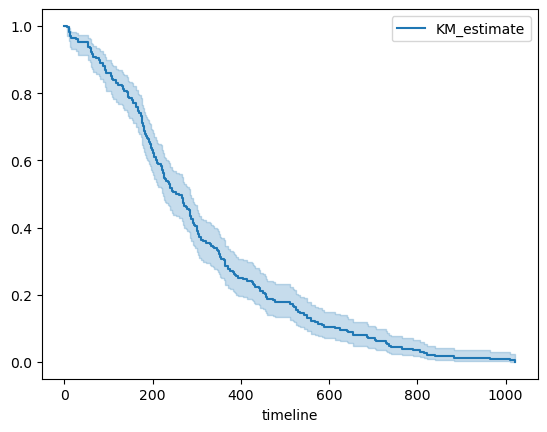

In [13]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf_fit = kmf.fit(cancer['time'], event_observed=cancer['status'])

kmf_fit.plot_survival_function();

In [32]:
# 필요한 정보
kmf_df = kmf.event_table.copy()
kmf_df['surv'] = kmf.survival_function_

kmf_df

,removed,observed,censored,entrance,at_risk,surv
event_at,,,,,,
0.0,0,0,0,228,228,1.000000
5.0,1,1,0,0,228,0.995614
11.0,3,3,0,0,227,0.982456
12.0,1,1,0,0,224,0.978070
13.0,2,2,0,0,223,0.969298
...,...,...,...,...,...,...
840.0,1,1,0,0,5,0.017544
883.0,1,1,0,0,4,0.013158
965.0,1,1,0,0,3,0.008772


In [39]:
# 특정 시간 생존 확률
kmf.survival_function_at_times(times=[180, 360])

180    0.697368
360    0.307018
Name: KM_estimate, dtype: float64

In [40]:
# 생존 확률 대표값 : 일반적으로 정규분포 기대하기 어려우며, 우꼬리 편향 => 평균 대신 중앙값 사용
kmf.median_survival_time_

252.0

In [48]:
# 특정 %일 때, 경과 일 수
target_percent = 0.3
kmf.survival_function_.loc[kmf.survival_function_['KM_estimate']<=target_percent].index.min()

363.0

male median time : 223.0000
female median time : 292.0000
sex group log-rank test p_val : 0.1467


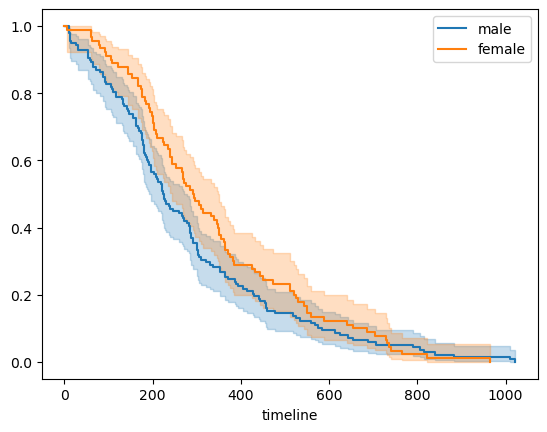

In [66]:
from lifelines.statistics import logrank_test

col = 'sex'
# 성별에 따라 생존 시간의 차이가 있는지 확인
for group in cancer[col].unique():
    group_data = cancer.loc[cancer[col]==group]
    kmf.fit(group_data['time'], event_observed=group_data['status'], label=f"{group}")
    kmf.plot_survival_function()
    print(f"{group} median time : {kmf.median_survival_time_:.4f}")

group_a = cancer.loc[cancer[col]=='male']
group_b = cancer.loc[cancer[col]=='female']

# H0 : no diff
print(f"{col} group log-rank test p_val : {logrank_test(group_a['time'], group_b['time'], event_observed_A=group_a['status'], event_observed_B=group_b['status']).p_value:.4f}")

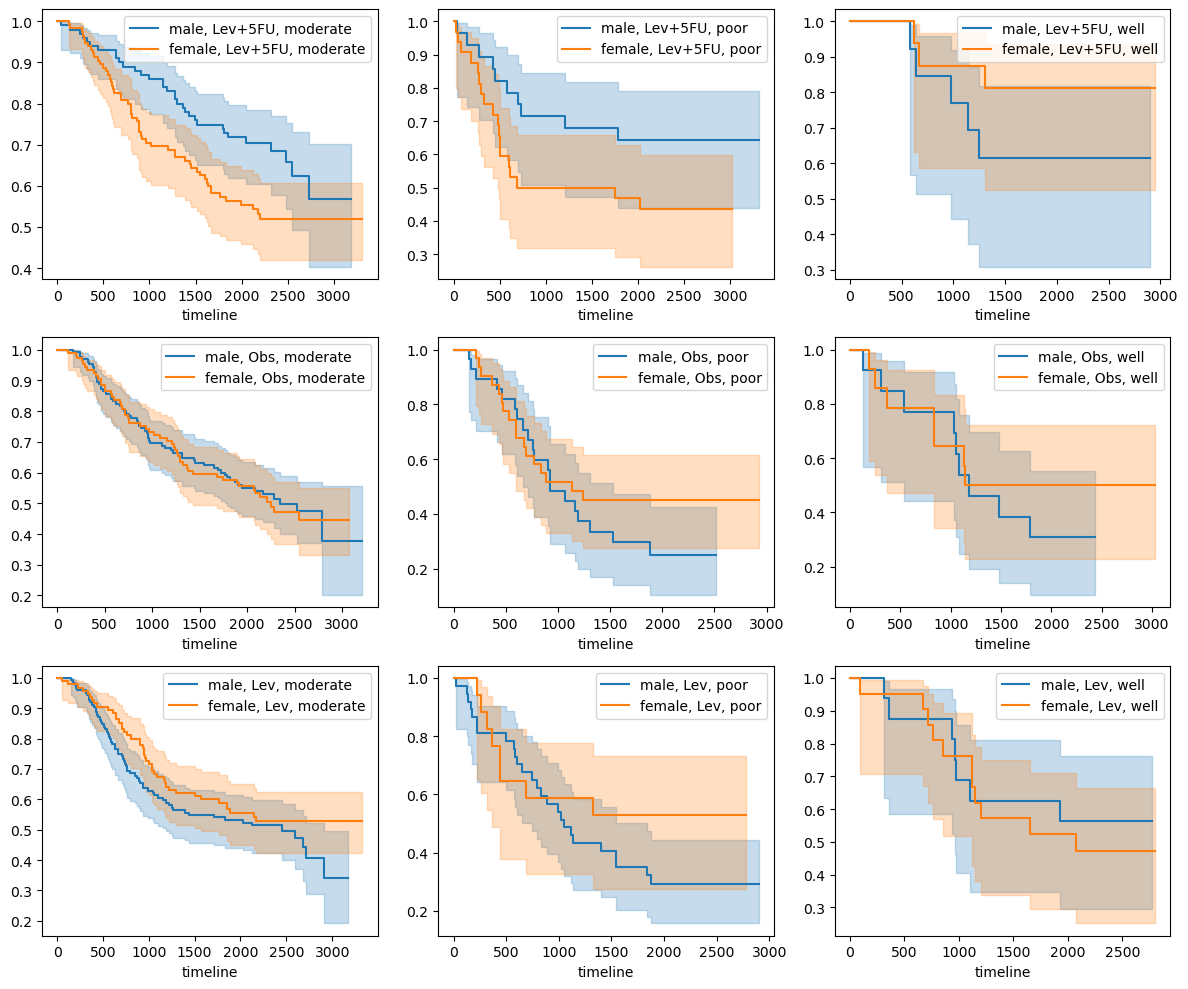

In [98]:
# 다중 집단에 대한 카플란 분석
colon = pd.read_csv('../data/kwak/colon.csv').drop('rownames', axis=1)

colon_death = colon.loc[colon['etype']==2] # 사망의 경우만 사용
colon_death['sex'] = list(map(lambda x : 'male' if x == 1 else 'female', colon_death['sex']))
colon_death['differ'] = list(map(lambda x : 'well' if x == 1 else ('moderate' if x == 2 else 'poor'), colon_death['differ']))

fig, axes = plt.subplots(3,3, figsize=(12,10))
i = 0
for rx in colon_death['rx'].unique():
    for differ in colon_death['differ'].unique():
        i = i + 1
        for sex in colon_death['sex'].unique():
            subset = colon_death.loc[(colon_death['sex']==sex) & (colon_death['rx']==rx) & (colon_death['differ']==differ)]
            if subset.empty:
                continue
            kmf.fit(subset['time'], event_observed=subset['status'], label=f'{sex}, {rx}, {differ}')
            kmf.plot_survival_function(ci_show=True, ax=axes[(i-1)//3, (i-1)%3])

plt.tight_layout()            
plt.show()

In [82]:
from lifelines.statistics import pairwise_logrank_test

result = pairwise_logrank_test(colon_death['time'], groups=colon_death['sex'] + '|' + colon_death['rx'] + '|' + colon_death['differ'], event_observed=colon_death['status'])
result.summary

test_statistic         p  \
female|Lev+5FU|moderate female|Lev+5FU|poor        2.710213  0.099708   
                        female|Lev+5FU|well        3.923823  0.047607   
                        female|Lev|moderate        0.019267  0.889602   
                        female|Lev|poor            0.210399  0.646455   
                        female|Lev|well            0.132704  0.715645   
...                                                     ...       ...   
male|Lev|well           male|Obs|poor              4.237609  0.039538   
                        male|Obs|well              1.505088  0.219890   
male|Obs|moderate       male|Obs|poor              8.706385  0.003171   
                        male|Obs|well              2.417673  0.119973   
male|Obs|poor           male|Obs|well              0.304416  0.581127   

                                             -log2(p)  
female|Lev+5FU|moderate female|Lev+5FU|poor  3.326152  
                        female|Lev+5FU|well  4.392697  
                        female|Lev|moderate  0.168767  
                        female|Lev|poor      0.629378  
                        female|Lev|well      0.482685  
...                                               ...  
male|Lev|well           male|Obs|poor        4.660623  
                        male|Obs|well        2.185145  
male|Obs|moderate       male|Obs|poor        8.300858  
                        male|Obs|well        3.059218  
male|Obs|poor           male|Obs|well        0.783074  

[153 rows x 3 columns]